# Phase 1: Automated Ticker Selection (Bias Removal)

## Objective
Instead of manually selecting stocks based on intuition, we will **systematically** compute Beta ($\beta$) for all S&P 500 constituents and select the top 30 high-beta and bottom 30 low-beta stocks. This removes human bias and ensures our analysis covers a diverse range of market sensitivities.

## Methodology
1. Load S&P 500 constituent tickers from `constituents.csv`
2. Download 1 year of daily adjusted close prices for all stocks + SPY (benchmark)
3. Calculate log returns: $R_t = \ln(P_t / P_{t-1})$
4. Compute Beta via linear regression: $R_{i,t} = \alpha + \beta R_{SPY,t} + \epsilon$
5. Sort stocks by Beta and extract:
   - **High Beta**: Top 30 stocks with $\beta > 1.5$ (high market sensitivity)
   - **Low Beta**: Bottom 30 stocks with $\beta < 0.7$ (low market sensitivity)
6. Save results to `data/tickers/high_beta.csv` and `data/tickers/low_beta.csv`

---

## 1. Import Libraries and Setup

In [1]:
import os

import pandas as pd
import numpy as np

import yfinance as yf

from scipy import stats
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## 2. Load S&P 500 Constituents

In [3]:
# Load the S&P 500 constituents
constituents_path = '/content/drive/MyDrive/market-sentiment-impact-analysis/data/raw/constituents.csv'
sp500 = pd.read_csv(constituents_path)

print(f'Total S&P 500 constituents loaded: {len(sp500)}')
print(f'\nColumns: {list(sp500.columns)}')
print(f'\nFirst 5 stocks:')
sp500.head()

Total S&P 500 constituents loaded: 477

Columns: ['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location', 'Date added', 'CIK', 'Founded']

First 5 stocks:


,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [4]:
tickers = sp500['Symbol'].tolist()

print(f'Total tickers extracted: {len(tickers)}')
print(f'\nSample tickers: {tickers[:10]}')
print(f'\nSpecial tickers to note:')
special_tickers = [t for t in tickers if '.' in t or t == 'XYZ']
print(special_tickers)

Total tickers extracted: 477

Sample tickers: ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']

Special tickers to note:
['XYZ']


## 3. Download Historical Price Data

In [5]:
end_date = datetime(2020, 7, 19)
start_date = datetime(2017, 12, 1)

print(f'Downloading data from {start_date.date()} to {end_date.date()}')

all_tickers = ['SPY'] + tickers
print(f'Total symbols to download {len(all_tickers)} (stocks + SPY)')
print('Downloading...')


Total symbols to download 478 (stocks + SPY)
Downloading...


In [6]:
prices = yf.download(
    all_tickers,
    start=start_date,
    end=end_date,
    auto_adjust=True,
    progress=True
)['Close']

print('\nDownload Complete')
print(f'Shape: {prices.shape} (rows = trading days, columns = stocks)')
print(f'Date range: {prices.index[0]} to {prices.index[-1]}')
print(f'Trading days: {len(prices)}')

[*********************100%***********************]  478 of 478 completed



Download Complete
Shape: (660, 478) (rows = trading days, columns = stocks)
Date range: 2017-12-01 00:00:00 to 2020-07-17 00:00:00
Trading days: 660


In [7]:
missing_data = prices.isnull().sum()
stocks_with_missing = missing_data[missing_data > 0].sort_values(ascending=False)

print(f'Stocks with missing data: {len(stocks_with_missing)}')
if len(stocks_with_missing) > 0:
    print(f'\nTop 10 stocks by missing data count:')
    print(stocks_with_missing.head(10))

    pct_missing = (stocks_with_missing / len(prices) * 100).head(10).apply(lambda x: f'{x:.2f}%')
    print('\nPercentage missing:')
    print(pct_missing.round(2))

Stocks with missing data: 1

Top 10 stocks by missing data count:
Ticker
VICI    20
dtype: int64

Percentage missing:
Ticker
VICI    3.03%
dtype: object


In [8]:
prices_filled = prices.fillna(method='ffill')

threshold = len(prices_filled) * 0.9
prices_clean = prices_filled.dropna(axis=1, thresh=threshold)

print(f'Stocks after cleaning: {len(prices_clean.columns)}')
print(f'Stocks removed: {len(prices.columns) - len(prices_clean.columns)}')

if len(prices.columns) - len(prices_clean.columns) > 0:
    removed = set(prices.columns) - set(prices_clean.columns)
    print(f'\nRemoved tickers: {sorted(removed)}')

Stocks after cleaning: 478
Stocks removed: 0


## 4. Calculate Log Returns

In [9]:
# Calculate log returns: R_t = ln(P_t / P_{t-1})

returns = np.log(prices_clean / prices_clean.shift(1))
returns = returns.dropna()

print(f'Returns shape: {returns.shape}')
print(f'Date range: {returns.index[0]} to {returns.index[-1]}')
print('\nSample returns for SPY (first 5 days):')
print(returns['SPY'].head())

Returns shape: (639, 478)
Date range: 2018-01-03 00:00:00 to 2020-07-17 00:00:00

Sample returns for SPY (first 5 days):
Date
2018-01-03    0.006305
2018-01-04    0.004206
2018-01-05    0.006642
2018-01-08    0.001827
2018-01-09    0.002260
Name: SPY, dtype: float64


In [10]:
spy_returns = returns['SPY']

print('SPY Return Statistics:')
print(f'Mean daily return: {spy_returns.mean():.6f} ({spy_returns.mean() * 252 * 100:.2f}% annualized)')
print(f'Std dev(daily): {spy_returns.std():.6f} ({spy_returns.std() * np.sqrt(252) * 100:.2f}% annualized)')
print(f'Min daily return: {spy_returns.min():.6f}')
print(f'Max daily return: {spy_returns.max():.6f}')

annualized_return = spy_returns.mean() * 252
annualized_vol = spy_returns.std() * np.sqrt(252)
sharpe = (annualized_return - 0.0166) / annualized_vol

# https://fred.stlouisfed.org/series/TB3MS
print(f'Sharpe Ratio (annualized, assuming 1.66% avg risk-free rate): {sharpe:.2f}')

SPY Return Statistics:
Mean daily return: 0.000356 (8.98% annualized)
Std dev(daily): 0.015084 (23.94% annualized)
Min daily return: -0.115886
Max daily return: 0.086731
Sharpe Ratio (annualized, assuming 1.66% avg risk-free rate): 0.31


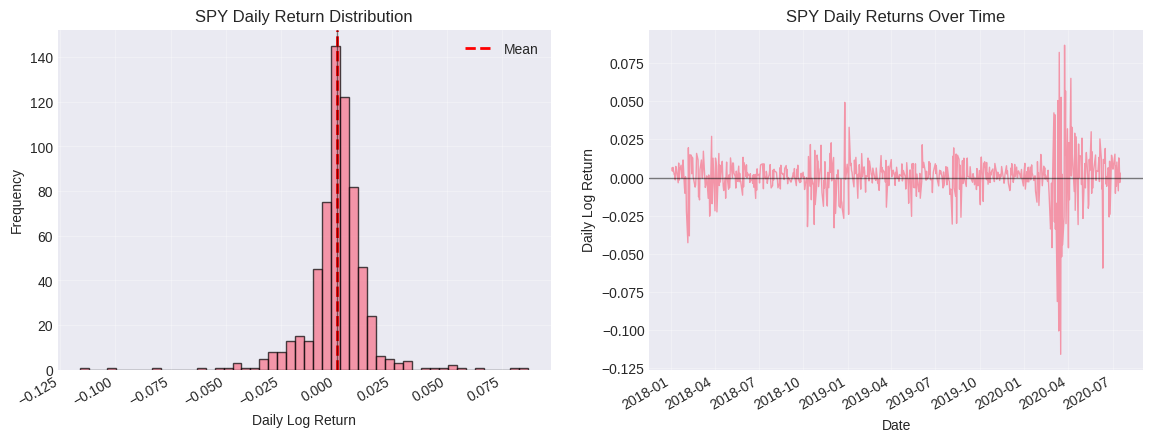

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(spy_returns, bins=50, alpha=0.7, edgecolor='black')
axes[0].axvline(spy_returns.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[0].set_xlabel('Daily Log Return')
axes[0].set_ylabel('Frequency')
axes[0].set_title('SPY Daily Return Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Time series
axes[1].plot(spy_returns.index, spy_returns, linewidth=1, alpha=0.7)
axes[1].axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Daily Log Return')
axes[1].set_title('SPY Daily Returns Over Time')
axes[1].grid(True, alpha=0.3)

fig.autofmt_xdate()

## 5. Compute Beta for All Stocks

In [12]:
benchmark_returns = returns['SPY'].values.reshape(-1, 1)

beta_results = []

stock_tickers = [col for col in returns.columns if col != 'SPY']

print(f'Computing beta for {len(stock_tickers)} stocks...')

for ticker in stock_tickers:
    try:
        stock_returns = returns[ticker].values.reshape(-1, 1)

        # Run linear regression: R_stock = alpha + beta * R_SPY + epsilon
        model = LinearRegression()
        model.fit(benchmark_returns, stock_returns)

        beta = model.coef_[0][0]
        alpha = model.intercept_[0]

        r_squared = model.score(benchmark_returns, stock_returns)
        correlation = np.corrcoef(benchmark_returns.flatten(), stock_returns.flatten())[0, 1]

        volatility = returns[ticker].std() * np.sqrt(252)

        beta_results.append({
            'Ticker': ticker,
            'Beta': beta,
            'Alpha': alpha,
            'R_Squared': r_squared,
            'Correlation': correlation,
            'Volatility': volatility
        })

    except Exception as e:
        print(f"Error processing {ticker}: {str(e)}")
        continue

print(f'Beta calculation complete for {len(beta_results)} stocks')

Computing beta for 477 stocks...
Beta calculation complete for 477 stocks


In [13]:
# Convert to DataFrame and sort by Beta
beta_df = pd.DataFrame(beta_results)
beta_df = beta_df.sort_values(by='Beta', ascending=False).reset_index(drop=True)

print('Beta Distribution Summary:')
print(beta_df['Beta'].describe())
print(f'\nStocks with Beta > 1.5: {len(beta_df[beta_df['Beta'] > 1.5])}')
print(f'Stocks with Beta < 0.7: {len(beta_df[beta_df['Beta'] < 0.7])}')
print(f'Stocks with Beta ≈ 1 (0.9-1.1): {len(beta_df[(beta_df['Beta'] >= 0.9) & (beta_df['Beta'] <= 1.1)])}')

Beta Distribution Summary:
count    477.000000
mean       1.067700
std        0.285662
min        0.290109
25%        0.869128
50%        1.055888
75%        1.225204
max        1.950480
Name: Beta, dtype: float64

Stocks with Beta > 1.5: 43
Stocks with Beta < 0.7: 36
Stocks with Beta ≈ 1 (0.9-1.1): 135


In [14]:
print('Top 10 Highest Beta Stocks:')
print(beta_df[['Ticker', 'Beta', 'R_Squared', 'Volatility']].head(10))
print('Top 10 Lowest Beta Stocks')
print(beta_df[['Ticker', 'Beta', 'R_Squared', 'Volatility']].tail(10))

Top 10 Highest Beta Stocks:
  Ticker      Beta  R_Squared  Volatility
0    APA  1.950480   0.286802    0.872084
1   NCLH  1.936777   0.324044    0.814678
2   CVNA  1.919910   0.309105    0.826868
3    CCL  1.837347   0.367965    0.725265
4   TRGP  1.830136   0.283161    0.823522
5    RCL  1.809572   0.371869    0.710542
6    MGM  1.790475   0.464033    0.629365
7    HAL  1.779043   0.446742    0.637333
8    AMP  1.770886   0.764730    0.484892
9    OXY  1.726238   0.329398    0.720192
Top 10 Lowest Beta Stocks
    Ticker      Beta  R_Squared  Volatility
467    CHD  0.488735   0.195378    0.264755
468    CAG  0.480203   0.104349    0.355950
469     SW  0.465149   0.059760    0.455610
470    HRL  0.450234   0.197805    0.242397
471    GIS  0.410536   0.136177    0.266384
472    SJM  0.385139   0.111950    0.275622
473    CPB  0.345294   0.073703    0.304548
474     KR  0.342843   0.063822    0.324953
475    CLX  0.330349   0.094816    0.256886
476    NEM  0.290109   0.042854    0.335565


## 6. Visualize Beta Distribution

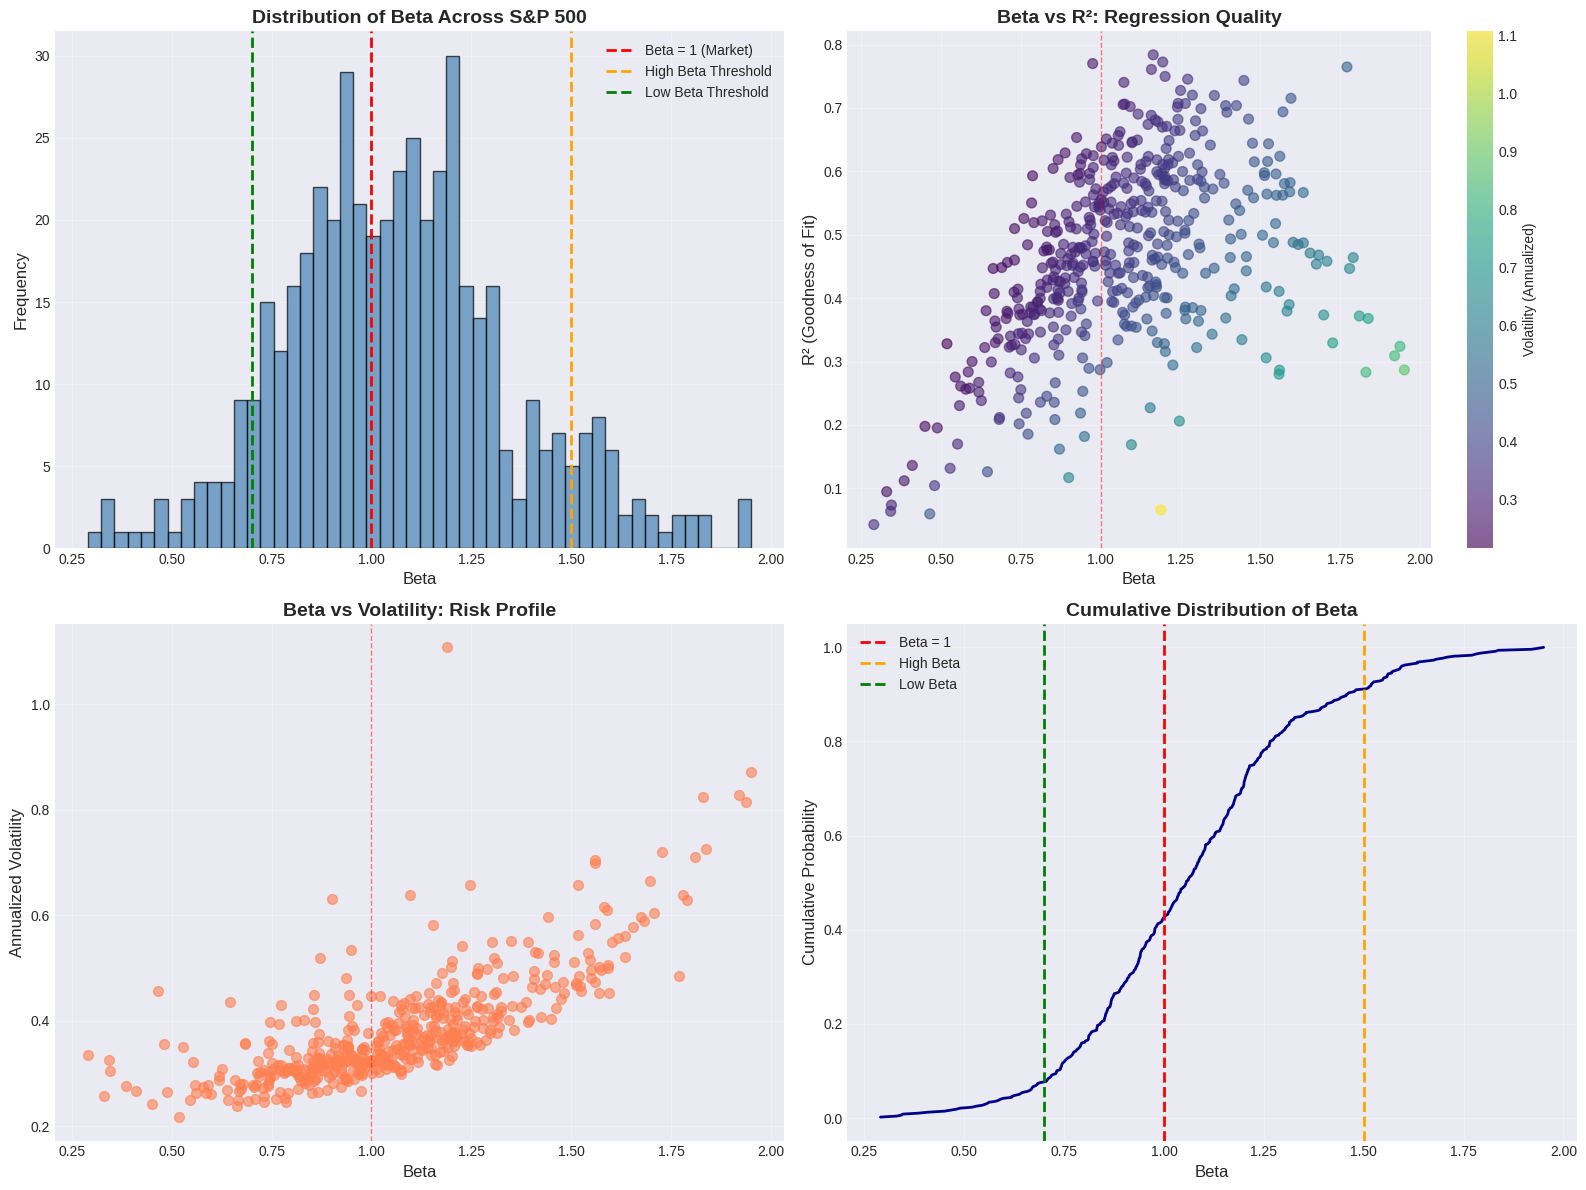

In [15]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Beta distribution histogram
axes[0, 0].hist(beta_df['Beta'], bins=50, alpha=0.7, edgecolor='black', color='steelblue')
axes[0, 0].axvline(1.0, color='red', linestyle='--', linewidth=2, label='Beta = 1 (Market)')
axes[0, 0].axvline(1.5, color='orange', linestyle='--', linewidth=2, label='High Beta Threshold')
axes[0, 0].axvline(0.7, color='green', linestyle='--', linewidth=2, label='Low Beta Threshold')
axes[0, 0].set_xlabel('Beta', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Distribution of Beta Across S&P 500', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Beta vs R-Squared
scatter = axes[0, 1].scatter(beta_df['Beta'], beta_df['R_Squared'],
                             alpha=0.6, c=beta_df['Volatility'], cmap='viridis', s=50)
axes[0, 1].set_xlabel('Beta', fontsize=12)
axes[0, 1].set_ylabel('R² (Goodness of Fit)', fontsize=12)
axes[0, 1].set_title('Beta vs R²: Regression Quality', fontsize=14, fontweight='bold')
axes[0, 1].axvline(1.0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 1].grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=axes[0, 1])
cbar.set_label('Volatility (Annualized)', fontsize=10)

# 3. Beta vs Volatility
axes[1, 0].scatter(beta_df['Beta'], beta_df['Volatility'], alpha=0.6, s=50, color='coral')
axes[1, 0].set_xlabel('Beta', fontsize=12)
axes[1, 0].set_ylabel('Annualized Volatility', fontsize=12)
axes[1, 0].set_title('Beta vs Volatility: Risk Profile', fontsize=14, fontweight='bold')
axes[1, 0].axvline(1.0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 0].grid(True, alpha=0.3)

# 4. Cumulative distribution
sorted_betas = np.sort(beta_df['Beta'])
cumulative = np.arange(1, len(sorted_betas) + 1) / len(sorted_betas)
axes[1, 1].plot(sorted_betas, cumulative, linewidth=2, color='darkblue')
axes[1, 1].axvline(1.0, color='red', linestyle='--', linewidth=2, label='Beta = 1')
axes[1, 1].axvline(1.5, color='orange', linestyle='--', linewidth=2, label='High Beta')
axes[1, 1].axvline(0.7, color='green', linestyle='--', linewidth=2, label='Low Beta')
axes[1, 1].set_xlabel('Beta', fontsize=12)
axes[1, 1].set_ylabel('Cumulative Probability', fontsize=12)
axes[1, 1].set_title('Cumulative Distribution of Beta', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Select High Beta and Low Beta Stocks

In [16]:
high_beta_candidates = beta_df[beta_df['Beta'] > 1.5].copy()
low_beta_candidates = beta_df[beta_df['Beta'] < 0.7].copy()

print(f'Stocks with Beta > 1.5: {len(high_beta_candidates)}')
print(f'Stocks with Beta < 0.7: {len(low_beta_candidates)}')

Stocks with Beta > 1.5: 43
Stocks with Beta < 0.7: 36


In [17]:
high_beta_stocks = beta_df.nlargest(30, 'Beta').copy()
low_beta_stocks = beta_df.nsmallest(30, 'Beta').copy()

print('HIGH BETA STOCKS (Top 30):')
print('='*80)
print(high_beta_stocks[['Ticker', 'Beta', 'R_Squared', 'Correlation', 'Volatility']].to_string(index=False))
print(f'\nMean Beta: {high_beta_stocks['Beta'].mean():.3f}')
print(f'Mean Volatility: {high_beta_stocks['Volatility'].mean():.3f}')
print(f'Mean R²: {high_beta_stocks['R_Squared'].mean():.3f}')

HIGH BETA STOCKS (Top 30):
Ticker     Beta  R_Squared  Correlation  Volatility
   APA 1.950480   0.286802     0.535539    0.872084
  NCLH 1.936777   0.324044     0.569249    0.814678
  CVNA 1.919910   0.309105     0.555972    0.826868
   CCL 1.837347   0.367965     0.606601    0.725265
  TRGP 1.830136   0.283161     0.532129    0.823522
   RCL 1.809572   0.371869     0.609810    0.710542
   MGM 1.790475   0.464033     0.681200    0.629365
   HAL 1.779043   0.446742     0.668388    0.637333
   AMP 1.770886   0.764730     0.874488    0.484892
   OXY 1.726238   0.329398     0.573932    0.720192
   XYZ 1.708295   0.458296     0.676975    0.604225
   DVN 1.698170   0.373515     0.611159    0.665328
    ON 1.682225   0.468053     0.684144    0.588769
   TPR 1.675084   0.453721     0.673588    0.595457
    BA 1.655419   0.471137     0.686394    0.577488
   FCX 1.634547   0.487184     0.697986    0.560737
   URI 1.634174   0.566613     0.752737    0.519833
   MPC 1.618295   0.484720     0.6962

In [18]:
print('LOW BETA STOCKS (Bottom 30):')
print('='*80)
print(low_beta_stocks[['Ticker', 'Beta', 'R_Squared', 'Correlation', 'Volatility']].to_string(index=False))
print(f'\nMean Beta: {low_beta_stocks['Beta'].mean():.3f}')
print(f'Mean Volatility: {low_beta_stocks['Volatility'].mean():.3f}')
print(f'Mean R²: {low_beta_stocks['R_Squared'].mean():.3f}')

LOW BETA STOCKS (Bottom 30):
Ticker     Beta  R_Squared  Correlation  Volatility
   NEM 0.290109   0.042854     0.207011    0.335565
   CLX 0.330349   0.094816     0.307922    0.256886
    KR 0.342843   0.063822     0.252629    0.324953
   CPB 0.345294   0.073703     0.271482    0.304548
   SJM 0.385139   0.111950     0.334589    0.275622
   GIS 0.410536   0.136177     0.369022    0.266384
   HRL 0.450234   0.197805     0.444753    0.242397
    SW 0.465149   0.059760     0.244459    0.455610
   CAG 0.480203   0.104349     0.323031    0.355950
   CHD 0.488735   0.195378     0.442016    0.264755
    VZ 0.518967   0.328092     0.572794    0.216945
   DPZ 0.528965   0.131675     0.362871    0.349046
   WMT 0.544945   0.275603     0.524979    0.248553
   KDP 0.552229   0.169920     0.412214    0.320778
    ED 0.558112   0.230542     0.480148    0.278326
   KMB 0.561837   0.261340     0.511215    0.263157
    DG 0.578291   0.256390     0.506349    0.273467
   AEP 0.585551   0.283642     0.53

## 8. Add Sector Information

In [19]:
high_beta_stocks = high_beta_stocks.merge(
    sp500[['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry']],
    left_on='Ticker',
    right_on='Symbol',
    how='left'
).drop('Symbol', axis=1)

low_beta_stocks = low_beta_stocks.merge(
    sp500[['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry']],
    left_on='Ticker',
    right_on='Symbol',
    how='left'
).drop('Symbol', axis=1)

print("Sector information added")

Sector information added


In [20]:
# Analyze sector distribution
print('HIGH BETA - Sector Distribution:')
high_beta_sectors = high_beta_stocks['GICS Sector'].value_counts()
print(high_beta_sectors)

print('\nLOW BETA - Sector Distribution:')
low_beta_sectors = low_beta_stocks['GICS Sector'].value_counts()
print(low_beta_sectors)

HIGH BETA - Sector Distribution:
GICS Sector
Energy                    8
Financials                8
Consumer Discretionary    7
Information Technology    3
Industrials               2
Materials                 1
Communication Services    1
Name: count, dtype: int64

LOW BETA - Sector Distribution:
GICS Sector
Consumer Staples          16
Utilities                  5
Materials                  2
Real Estate                2
Communication Services     1
Consumer Discretionary     1
Industrials                1
Health Care                1
Information Technology     1
Name: count, dtype: int64


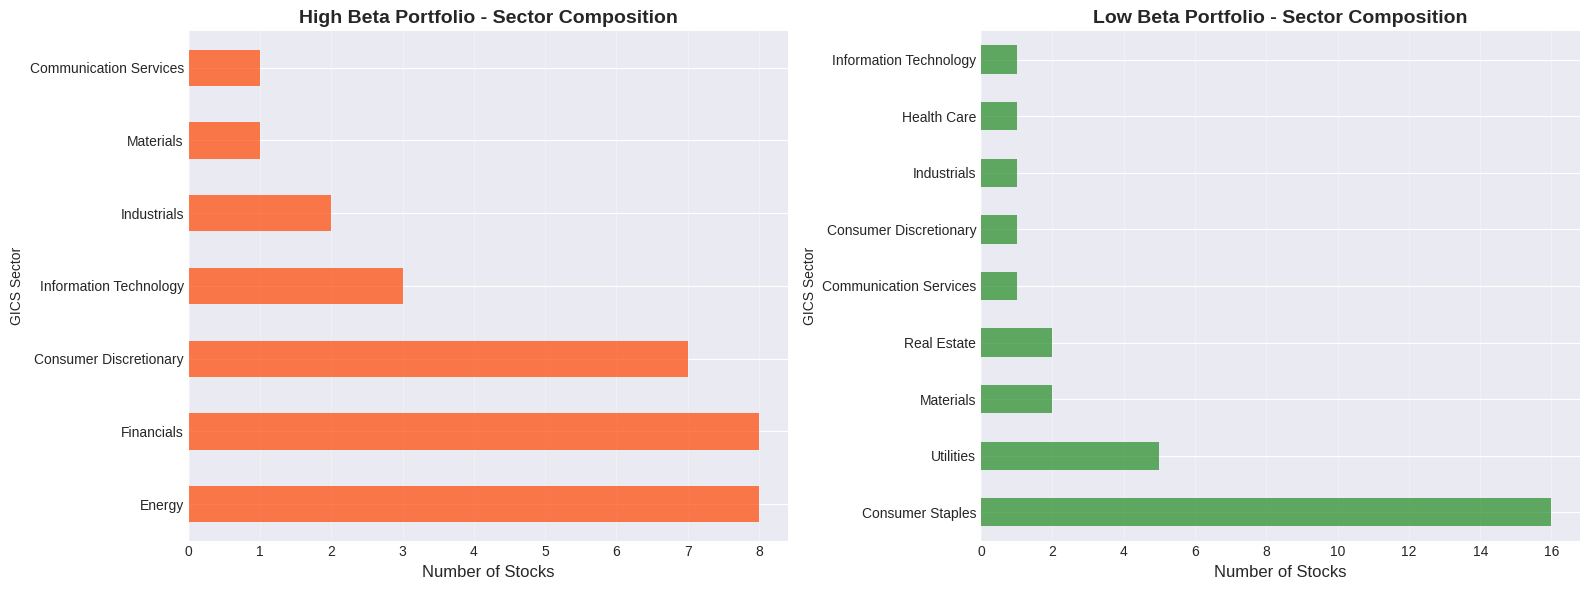

In [21]:
# Visualize sector composition
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# High Beta sectors
high_beta_sectors.plot(kind='barh', ax=axes[0], color='orangered', alpha=0.7)
axes[0].set_xlabel('Number of Stocks', fontsize=12)
axes[0].set_title('High Beta Portfolio - Sector Composition', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Low Beta sectors
low_beta_sectors.plot(kind='barh', ax=axes[1], color='forestgreen', alpha=0.7)
axes[1].set_xlabel('Number of Stocks', fontsize=12)
axes[1].set_title('Low Beta Portfolio - Sector Composition', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 9. Save Results

In [22]:
project_root = '/content/drive/MyDrive/market-sentiment-impact-analysis'
output_dir = os.path.join(project_root, 'data', 'tickers')
os.makedirs(output_dir, exist_ok=True)
print(f"Saving files to: {output_dir}")

output_columns = ['Ticker', 'Security', 'GICS Sector', 'Beta', 'R_Squared', 'Volatility']

# Save high beta stocks
high_beta_output = high_beta_stocks[output_columns].copy()
high_beta_output.to_csv(os.path.join(output_dir, 'high_beta.csv'), index=False)
print(f'Saved high_beta.csv ({len(high_beta_output)} stocks)')

# Save low beta stocks
low_beta_output = low_beta_stocks[output_columns].copy()
low_beta_output.to_csv(os.path.join(output_dir, 'low_beta.csv'), index=False)
print(f'Saved low_beta.csv ({len(low_beta_output)} stocks)')

# Also save complete beta analysis for reference
beta_df_full = beta_df.merge(
    sp500[['Symbol', 'Security', 'GICS Sector']],
    left_on='Ticker',
    right_on='Symbol',
    how='left'
).drop('Symbol', axis=1)
beta_df_full.to_csv(os.path.join(output_dir, 'all_betas.csv'), index=False)
print(f'Saved all_betas.csv')

Saving files to: /content/drive/MyDrive/market-sentiment-impact-analysis/data/tickers
Saved high_beta.csv (30 stocks)
Saved low_beta.csv (30 stocks)
Saved all_betas.csv


## 10. Summary Statistics and Validation

In [23]:
summary_data = {
    'Metric': [
        'Number of Stocks',
        'Mean Beta',
        'Median Beta',
        'Std Dev Beta',
        'Min Beta',
        'Max Beta',
        'Mean Volatility',
        'Mean R²',
        'Mean Correlation'
    ],
    'High Beta Portfolio': [
        len(high_beta_stocks),
        high_beta_stocks['Beta'].mean(),
        high_beta_stocks['Beta'].median(),
        high_beta_stocks['Beta'].std(),
        high_beta_stocks['Beta'].min(),
        high_beta_stocks['Beta'].max(),
        high_beta_stocks['Volatility'].mean(),
        high_beta_stocks['R_Squared'].mean(),
        high_beta_stocks['Correlation'].mean()
    ],
    'Low Beta Portfolio': [
        len(low_beta_stocks),
        low_beta_stocks['Beta'].mean(),
        low_beta_stocks['Beta'].median(),
        low_beta_stocks['Beta'].std(),
        low_beta_stocks['Beta'].min(),
        low_beta_stocks['Beta'].max(),
        low_beta_stocks['Volatility'].mean(),
        low_beta_stocks['R_Squared'].mean(),
        low_beta_stocks['Correlation'].mean()
    ]
}

summary_df = pd.DataFrame(summary_data)
print('\nPORTFOLIO COMPARISON SUMMARY')
print('='*80)
print(summary_df.to_string(index=False))


PORTFOLIO COMPARISON SUMMARY
          Metric  High Beta Portfolio  Low Beta Portfolio
Number of Stocks            30.000000           30.000000
       Mean Beta             1.686906            0.535042
     Median Beta             1.644983            0.559974
    Std Dev Beta             0.121210            0.112461
        Min Beta             1.558385            0.290109
        Max Beta             1.950480            0.669166
 Mean Volatility             0.615615            0.290645
         Mean R²             0.462038            0.222644
Mean Correlation             0.672903            0.455310


In [24]:
# Statistical test: Compare beta distributions
from scipy.stats import ttest_ind, mannwhitneyu

# T-test for difference in means
t_stat, p_value_t = ttest_ind(high_beta_stocks['Beta'], low_beta_stocks['Beta'])

# Mann-Whitney U test (non-parametric alternative)
u_stat, p_value_u = mannwhitneyu(high_beta_stocks['Beta'], low_beta_stocks['Beta'])

print('\nSTATISTICAL VALIDATION')
print('='*80)
print(f'Hypothesis Test: Are high-beta and low-beta portfolios statistically different?')
print(f"\nT-Test Results:")
print(f'  T-statistic: {t_stat:.4f}')
print(f'  P-value: {p_value_t:.2e}')
print(f'  Result: {'SIGNIFICANT' if p_value_t < 0.001 else 'Not significant'} (α = 0.001)')

print(f'\nMann-Whitney U Test Results:')
print(f'  U-statistic: {u_stat:.4f}')
print(f'  P-value: {p_value_u:.2e}')
print(f'  Result: {'SIGNIFICANT' if p_value_u < 0.001 else 'Not significant'} (α = 0.001)')

print(f'\n Conclusion: The two portfolios are {'clearly distinct' if p_value_t < 0.001 else 'not sufficiently distinct'}')


STATISTICAL VALIDATION
Hypothesis Test: Are high-beta and low-beta portfolios statistically different?

T-Test Results:
  T-statistic: 38.1565
  P-value: 8.77e-43
  Result: SIGNIFICANT (α = 0.001)

Mann-Whitney U Test Results:
  U-statistic: 900.0000
  P-value: 3.02e-11
  Result: SIGNIFICANT (α = 0.001)

 Conclusion: The two portfolios are clearly distinct


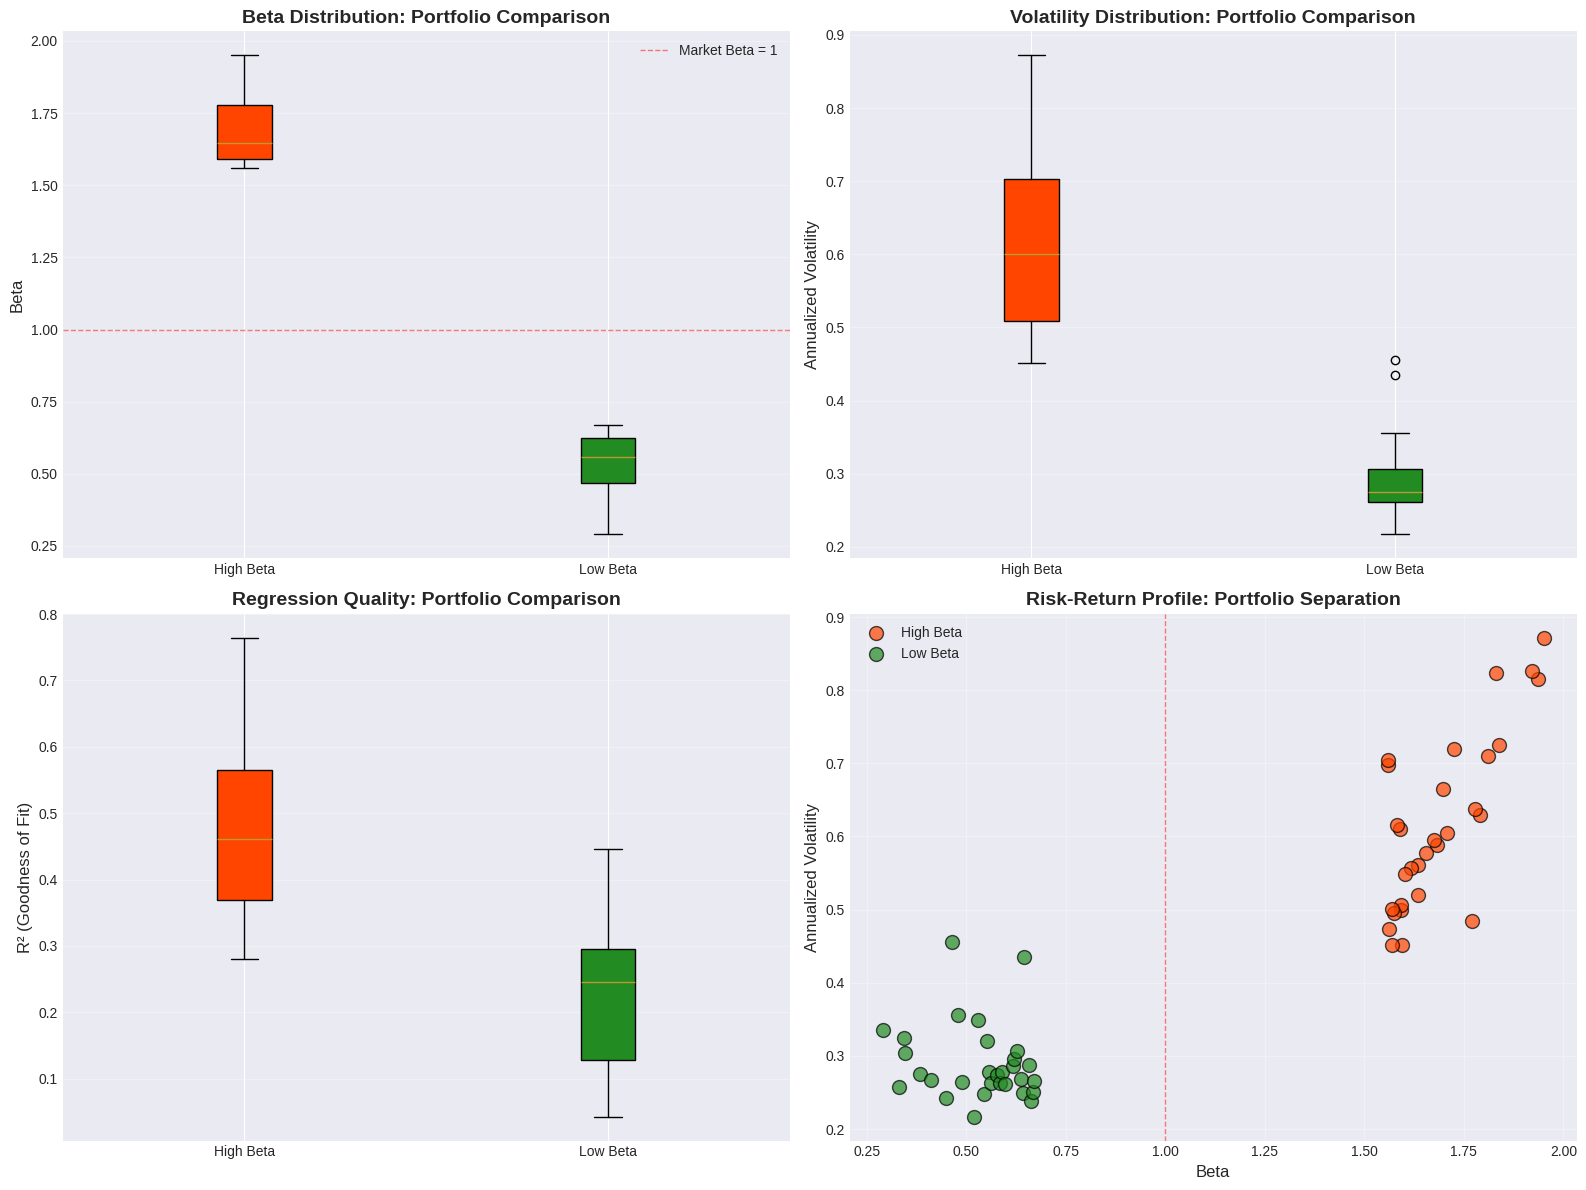

In [25]:
# visualization comparing the two portfolios
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

data_to_plot = [high_beta_stocks['Beta'], low_beta_stocks['Beta']]
bp = axes[0, 0].boxplot(data_to_plot, labels=['High Beta', 'Low Beta'], patch_artist=True)
bp['boxes'][0].set_facecolor('orangered')
bp['boxes'][1].set_facecolor('forestgreen')
axes[0, 0].set_ylabel('Beta', fontsize=12)
axes[0, 0].set_title('Beta Distribution: Portfolio Comparison', fontsize=14, fontweight='bold')
axes[0, 0].axhline(1.0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Market Beta = 1')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

data_to_plot_vol = [high_beta_stocks['Volatility'], low_beta_stocks['Volatility']]
bp_vol = axes[0, 1].boxplot(data_to_plot_vol, labels=['High Beta', 'Low Beta'], patch_artist=True)
bp_vol['boxes'][0].set_facecolor('orangered')
bp_vol['boxes'][1].set_facecolor('forestgreen')
axes[0, 1].set_ylabel('Annualized Volatility', fontsize=12)
axes[0, 1].set_title('Volatility Distribution: Portfolio Comparison', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

data_to_plot_r2 = [high_beta_stocks['R_Squared'], low_beta_stocks['R_Squared']]
bp_r2 = axes[1, 0].boxplot(data_to_plot_r2, labels=['High Beta', 'Low Beta'], patch_artist=True)
bp_r2['boxes'][0].set_facecolor('orangered')
bp_r2['boxes'][1].set_facecolor('forestgreen')
axes[1, 0].set_ylabel('R² (Goodness of Fit)', fontsize=12)
axes[1, 0].set_title('Regression Quality: Portfolio Comparison', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

axes[1, 1].scatter(high_beta_stocks['Beta'], high_beta_stocks['Volatility'],
                   alpha=0.7, s=100, c='orangered', label='High Beta', edgecolors='black')
axes[1, 1].scatter(low_beta_stocks['Beta'], low_beta_stocks['Volatility'],
                   alpha=0.7, s=100, c='forestgreen', label='Low Beta', edgecolors='black')
axes[1, 1].set_xlabel('Beta', fontsize=12)
axes[1, 1].set_ylabel('Annualized Volatility', fontsize=12)
axes[1, 1].set_title('Risk-Return Profile: Portfolio Separation', fontsize=14, fontweight='bold')
axes[1, 1].axvline(1.0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 1].legend(loc='upper left', fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Discussion & Limitations

### A. Addressing Survivorship Bias
This project utilizes the `fetch_sp500.py` module to retrieve historical price data for companies currently listed in the S&P 500. Because the script queries the current list of constituents (as of Feb 2026) and retroactively pulls data from 2018 – 2020, this introduces **Survivorship Bias**.
- **The Bias:** Companies that were in the S&P 500 during 2018 – 2020 but subsequently went bankrupt, merged, or were delisted (e.g., specific Energy or Retail firms that failed during the pandemic) are excluded from this analysis.
- **Impact:** Our dataset likely skews towards financially robust companies that "survived" the period. While this limits the analysis of distressed assets, it ensures we are analyzing liquid, tradable entities relevant to modern institutional portfolios.

### B. Interpreting the "High Beta" Sector Distribution
The resulting "High Beta" list is dominated by **Energy**, **Financials**, and **Consumer Discretionary**, with a notable absence of large-cap **Technology** stocks. This distribution is an accurate reflection of the specific volatility regimes present in the 2018 – 2020 window:
1. **The COVID-19 Crash (Feb–March 2020):** This period dominates the volatility calculation. During the crash, Energy stocks (impacted by the oil price collapse) and Financials (impacted by credit risk fears) exhibited extreme sensitivity, often falling 2x–3x more than the S&P 500. This resulted in mathematically higher Betas (>1.5).
2. **Tech as a Defensive Asset:** Conversely, major Technology stocks acted as a "safety trade" due to the work-from-home paradigm. While volatile, they were less volatile than the broader market collapse, resulting in Betas closer to 1.0–1.2, keeping them out of the top 30 "High Beta" selection.

### C. Suitability for Sentiment Analysis
Despite the lack of Tech stocks, the "High Beta" list (Energy/Financials) is ideal for **Market Sentiment Impact Analysis**. These sectors were the epicenter of news flow during this period (e.g., headlines about "Oil Supply Shocks," "Fed Rate Cuts," and "Bank Liquidity").

Testing our Sentiment Models (VADER vs. FinBERT) on these highly sensitive sectors will provide a clearer signal-to-noise ratio than testing on lower-volatility Tech stocks during this specific timeframe.